# Convergence 2D plots for didactic purposes

Run all the cells of the notebook to get the convergence and 2D plots of Gradient Descent (GD), Stochastic Gradient Descent (SGD) with constant step size and SAGA with constant step size applied to solve a regularized logistic regression problem. 

    Author: Nidham Gazagnadou
    Based on the code of: Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias

# 0. Imports

In [60]:
%matplotlib inline

In [61]:
from time import time

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import numpy as np
from scipy.linalg import norm
from numba import jit, njit

from scipy.optimize import check_grad
from scipy.optimize import fmin_l_bfgs_b

from numpy.random import seed
seed(42) # Set the random number generator to a fixed sequence.

In [62]:
# choose a large font size by default and use tex for math
usetex = True # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

# 1. Premilinary functions

## 1.0. Regularized logistic regression: loss function, gradient and step-size


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For logistic regression, the gradient is
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAGA it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [63]:
@njit
# @jit(nopython=False)
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x

@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n

def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.

def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [64]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, np.sign(b)

### Define a class to monitor iterations

In [65]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list, time_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.time_list = time_list
        self.err = [norm(x - self.x_min) for x in x_list] # ||w_k - w^*||_2
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

Let us define some plotting functions.

In [66]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
#     plt.savefig("gd_vs_sgd_vs_saga.svg")

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

And for level sets plots

In [67]:
def loss_2_args(x, y):
    return loss(np.array([x, y]), A, b, lbda)

def tabulate(x, y, f):
    """Return a table of f(x, y)."""
    return np.vectorize(f)(*np.meshgrid(x, y))

## 1.1 Algorithms used in this notebook

### Gradient Descent (GD)
We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

In [68]:
# @njit # not working
@jit(nopython=False)
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    x_list.append(x.copy())
    time_list = []
    time_elapsed = 0.;
    time_list.append(time_elapsed)
    for i in range(n_iter):
        ### GD
        t0 = time()
        x -= step * grad(x, *args)
        time_elapsed += time() - t0
        ### END OF GD
        if i % store_every == 0:
            x_list.append(x.copy())
            time_list.append(time_elapsed)
    return x, x_list, time_list

### Stochastic Gradient Descent (SGD)
We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

In [69]:
# @njit # not working
@jit(nopython=False)
def sgd(x_init, iis, grad_i, n_iter=100, step=1., step_const=True, store_every=1, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    x_list.append(x.copy())
    time_list = []
    time_elapsed = 0.;
    time_list.append(time_elapsed)
    for idx in range(n_iter):
        
        ### SGD
        if step_const:
            t0 = time()
            i = iis[idx]
            x -= step * grad_i(i, x, *args)
            time_elapsed += time() - t0
        else:
            t0 = time()
            i = iis[idx]
            x -= step / np.sqrt(idx + 1) * grad_i(i, x, *args)
            time_elapsed += time() - t0
        ### END OF SGD
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
            time_list.append(time_elapsed)
    return x, x_list, time_list

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

### SAGA

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i$ uniformly at random in $\{1, \ldots, n\}$

2. Compute and store a stochastic gradient
$$
g_i^\text{new} \gets \nabla f_{i}(x_t)
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta (g_i^\text{new} - g_i^t + G_t)$$
where $\eta$ is the step-size (see code below) and $G_t := \frac 1n \sum_{j=1}^n g_j^t$ is the average of previously stored gradients.

4. Store the computed stochastic gradient
$$
g_i^t \gets g_i^\text{new}
$$

5. Update of the average of gradients
$$
G_{t+1} \gets G_t + \frac{(g_i^\text{new} - g_i^t)}{n}
$$


In [70]:
# @njit # not working
@jit(nopython=False)
def saga(x_init, iis, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """SAGA algorithm."""
    x = x_init.copy()
    x_list = []
    x_list.append(x.copy())
    time_list = []
    time_elapsed = 0.;
    time_list.append(time_elapsed)
    
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    for idx in range(n_iter):

        ### SAGA
        t0 = time()
        i = iis[idx]
        
        grad_i_new = grad_i(i, x, *args)
        x -= step * (grad_i_new - gradient_memory[i] + averaged_gradient)
        averaged_gradient += (grad_i_new - gradient_memory[i]) / n
        gradient_memory[i] = grad_i_new
        time_elapsed += time() - t0
        ### END OF SAGA
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
            time_list.append(time_elapsed)
    return x, x_list, time_list

# 2. Generate data

In [71]:
save_figures = True # Set to "True" to save figures

d = 2
# n = 1000
n = 100000
idx = np.arange(d)

# Ground truth coefficients of the model
x1 = 1.0
x2 = 2.0
x_model_truth = np.array([x1, x2])

# Parameters of the data
std = 0.
corr = .75

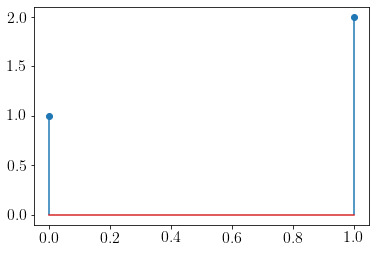

In [72]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [73]:
lbda = 1. / n ** (0.5)
A, b = simu_logreg(x_model_truth, n, std=std, corr=corr)

# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

4.353527018194206e-09

### Generating the regularized logistic regression model

In [187]:
A, b = simu_logreg(x_model_truth, n, std=std, corr=corr)
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
lbda = 1. / n ** (0.5)
print("lambda = %s" % lbda)

lambda = 0.003162277660168379


In [188]:
print(np.linalg.cond(A))

alpha = 5
print(np.linalg.cond(A / np.exp(alpha*np.arange(1,n+1)).reshape(-1, 1)))
A = A / np.exp(alpha*np.arange(1,n+1)).reshape(-1, 1)

2.6343392282416027
1140.2806247451588


<ipython-input-188-9892de63619c>:4: RuntimeWarning: overflow encountered in exp
  print(np.linalg.cond(A / np.exp(alpha*np.arange(1,n+1)).reshape(-1, 1)))
<ipython-input-188-9892de63619c>:5: RuntimeWarning: overflow encountered in exp
  A = A / np.exp(alpha*np.arange(1,n+1)).reshape(-1, 1)


### Compute the theoretical step-size for gradient descent

In [189]:
step = 1. / lipschitz_constant(A, b, lbda)
print("step = %s" % step)

step = 316.22776303390185


### Get a very precise minimum to compute distances to minimum

In [190]:
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

print(f_min)
print(norm(grad(x_min, A, b, lbda)))

0.6931471805598973
3.7893725687112424e-20


### Gap between the solution of the optimization problem and the truth model

In [191]:
print(x_min)
print(x_model_truth)

[1.49090832e-06 5.30151476e-06]
[1. 2.]


In [192]:
# Number of iterations/epochs (??)
n_iter = 100

### Designing a square grid for 2D plots once for all

In [193]:
delta = 0.1
# alpha = 1.5

# Designing a squared grid
x_grid_min = min(min(x_min[0], x_init[0]), min(x_min[1], x_init[1])) - 1.0
y_grid_min = x_grid_min
x_grid_max = max(max(x_min[0], x_init[0]), max(x_min[1], x_init[1])) + 2.0
y_grid_max = x_grid_max

x = np.arange(x_grid_min, x_grid_max, delta)
y = np.arange(y_grid_min, y_grid_max, delta)

X, Y = np.meshgrid(x, y)
Z = tabulate(x, y, loss_2_args)

nb_ellipses = 40

### Level-sets of the function and the solution

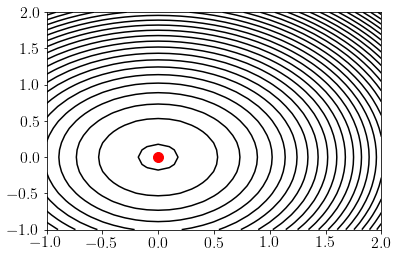

In [194]:
plt.figure()
# CS = plt.contour(X, Y, Z, nb_ellipses) # colored level-sets
CS = plt.contour(X, Y, Z, nb_ellipses, colors='k')
# plt.clabel(CS, inline=1, fontsize=10) # Show value of level-sets
plt.scatter(x_min[0], x_min[1], s=100, c='r', marker='o') # Solution of the optim problem (L-BFGS)
plt.show()

# 3. Gradient descent (GD)

In [195]:
step = 1. / lipschitz_constant(A, b, lbda)
monitor_gd = monitor(gd, loss, x_min, (A, b , lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))
relative_error_gd = [(x / monitor_gd.err[0])**2 for x in monitor_gd.err]

In [196]:
print("GD: final distance to the solution: %.2e" % monitor_gd.err[-1])

GD: final distance to the solution: 1.13e-17


### Iteration\epoch (because it's GD) convergence plot of the iterates  

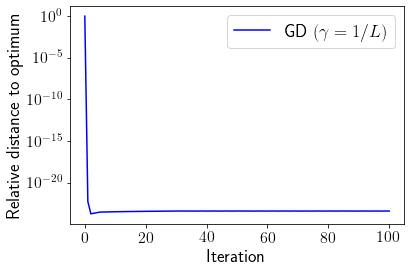

In [197]:
plt.semilogy(np.arange(n_iter+1), relative_error_gd, "b", label=r"GD $\left(\gamma = 1 / L\right)$")
# plt.xlabel("Epoch")
plt.xlabel("Iteration")
plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
# plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
plt.legend()

if save_figures:
    plt.savefig('images/gd_convergence_epoch_ill_conditioned.svg', bbox_inches='tight')
plt.show()

### Time convergence plot of the iterates  

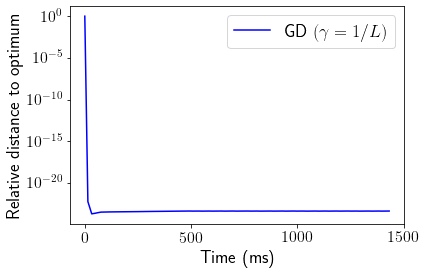

In [198]:
plt.semilogy([t*1000 for t in monitor_gd.time_list], relative_error_gd, "b", label=r"GD $\left(\gamma = 1 / L\right)$")
plt.xlabel("Time (ms)")
plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
# plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
plt.legend()
if save_figures:
    plt.savefig('images/gd_convergence_time_ill_conditioned.svg', bbox_inches='tight')
plt.show()

### Level-set plot

In [199]:
# plt.figure()
# CS = plt.contour(X, Y, Z, nb_ellipses)
# # plt.clabel(CS, inline=1, fontsize=10) # Show value of level-sets
# plt.scatter(np.vstack(monitor_gd.x_list)[:,0], np.vstack(monitor_gd.x_list)[:,1], marker='o',
#             s=60, facecolors='none', edgecolors='b', label=r"$\gamma = 1 / L$")
# plt.scatter(x_min[0], x_min[1], s=100, c='r', marker='o') # Solution of the optim problem (L-BFGS)
# plt.legend()
# # if save_figures:
# #     plt.savefig('images/gd_convergence_path.svg', bbox_inches='tight')
# plt.show()

### Level-set plot with a colorbar monitoring iterations

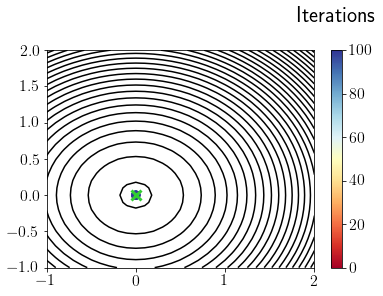

In [200]:
plt.figure()
CS = plt.contour(X, Y, Z, nb_ellipses, colors='k')

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(np.vstack(monitor_gd.x_list)[:,0], np.vstack(monitor_gd.x_list)[:,1], 
                 c=np.arange(len(monitor_gd.x_list)), marker='o', s=60, cmap=cm, zorder=2)
clb = plt.colorbar(sc)
clb.ax.set_title('Iterations\n')

plt.scatter(x_min[0], x_min[1], s=100, linewidth=3, c='limegreen', marker='x', zorder=2) # Solution of the optim problem (L-BFGS)

# plt.title(r"$\gamma = 1 / L$")

if save_figures:
    plt.savefig('images/gd_convergence_path_iteration_colorbar_ill_conditioned.pdf', bbox_inches='tight')
plt.show()

# 4. SGD 
## (small number of iterations)

### Stochastic indices

In [28]:
# Generate indices of random samples
iis = np.random.randint(0, n, n_iter)

### Select the step size here

The step size is: 0.01
SGD: final distance to the solution: 4.89e+00


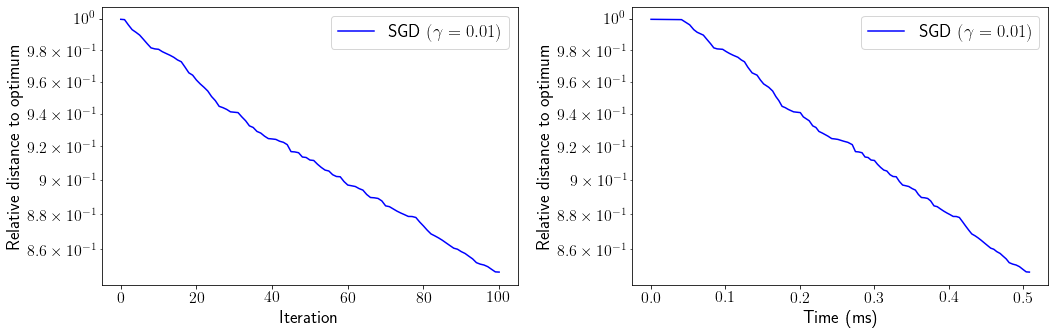

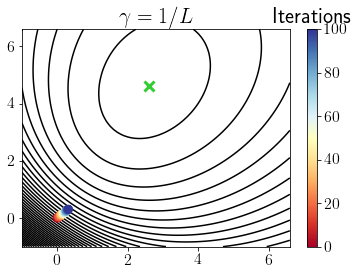

The step size is: 0.1
SGD: final distance to the solution: 3.48e+00


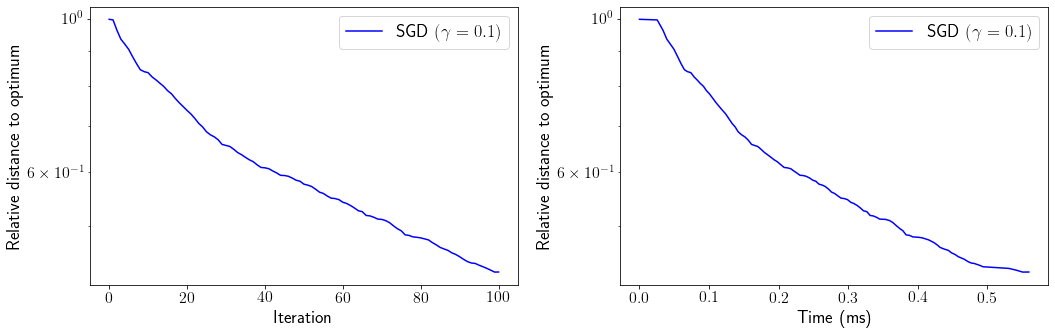

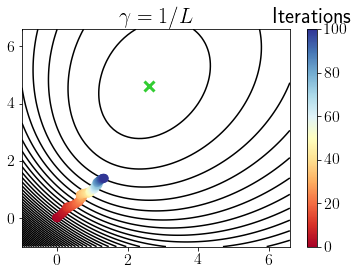

The step size is: 1.0
SGD: final distance to the solution: 1.19e+00


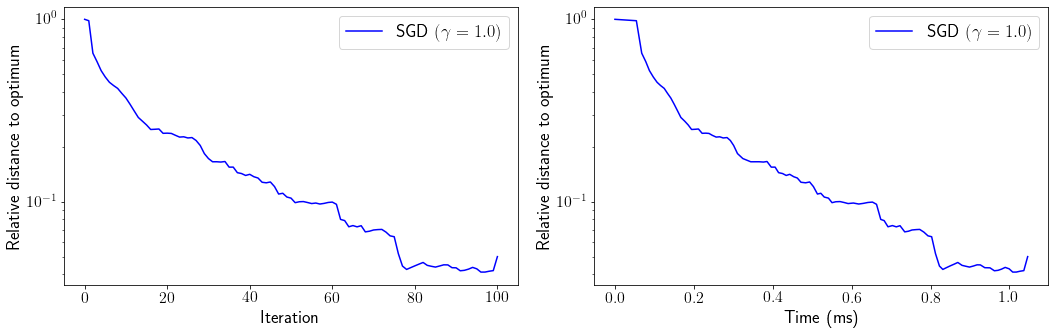

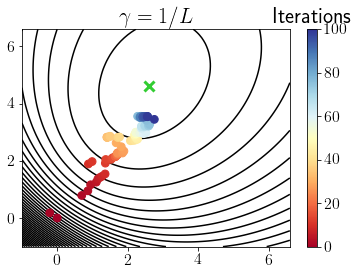

The step size is: 4.0
SGD: final distance to the solution: 1.21e+00


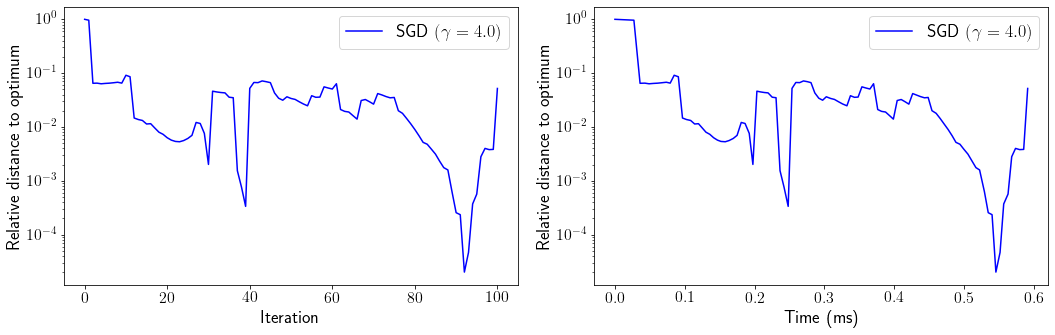

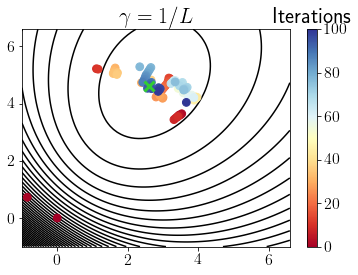

In [29]:
step_sgd_list = np.array([1e-2, 1e-1, 1., 4.])
for step_sgd in step_sgd_list:
    print('The step size is:', step_sgd)

    ## Optimization
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, iis, grad_i,
                    step=step_sgd, 
                    step_const=True, 
                    n_iter=n_iter, store_every=1,
                    args=(A, b, lbda))
    relative_error_sgd = [(x / monitor_sgd.err[0])**2 for x in monitor_sgd.err]
    print("SGD: final distance to the solution: %.2e" % monitor_sgd.err[-1])

    ## Convergence of the iterates (epoch figure)
    fig = plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.semilogy(np.arange(n_iter+1), relative_error_sgd, "b", label=r"SGD $\left(\gamma = {}\right)$".format(step_sgd))
    plt.xlabel("Iteration")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
#     if save_figures:
#         step_str = str(step_sgd).replace(".", "_")
#         plt.savefig('images/sgd_convergence_iteration_step_size_' + step_str + '.svg', bbox_inches='tight')
    
    ## Convergence of the iterates (time figure)
    plt.subplot(1,2,2)
    plt.semilogy([t*1000 for t in monitor_sgd.time_list], relative_error_sgd, "b", 
                 label=r"SGD $\left(\gamma = {}\right)$".format(step_sgd))
    plt.xlabel("Time (ms)")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
    plt.tight_layout()
#     if save_figures:
#         step_str = str(step_sgd).replace(".", "_")
#         plt.savefig('images/sgd_convergence_time_step_size_' + step_str + '.svg', bbox_inches='tight')
    if save_figures:
        step_str = str(step_sgd).replace(".", "_")
        plt.savefig('images/sgd_convergence_step_size_' + step_str + '.svg', bbox_inches='tight')
    plt.show()

    ## 2D path plot with iteration colorbar
    CS = plt.contour(X, Y, Z, nb_ellipses, colors='k')
    cm = plt.cm.get_cmap('RdYlBu')
    sc = plt.scatter(np.vstack(monitor_sgd.x_list)[:,0], np.vstack(monitor_sgd.x_list)[:,1],
                c=np.arange(len(monitor_sgd.x_list)), marker='o', s=60, cmap=cm, zorder=2)
    clb = plt.colorbar(sc)
    clb.ax.set_title('Iterations')
    plt.scatter(x_min[0], x_min[1], s=100, linewidth=3, c='limegreen', marker='x', zorder=2) # Solution of the optim problem (L-BFGS)
    plt.title(r"$\gamma = 1 / L$")

    if save_figures:
        step_str = str(step_sgd).replace(".", "_")
        plt.savefig('images/sgd_path_step_size_' + step_str + '_iteration_colorbar.svg', bbox_inches='tight')
    plt.show()

# 5. Stochastic variance reduced methods 
## (small number of iterations, no variance-reduction)

The step size is: 0.01
SAGA: final distance to the solution: 4.89e+00


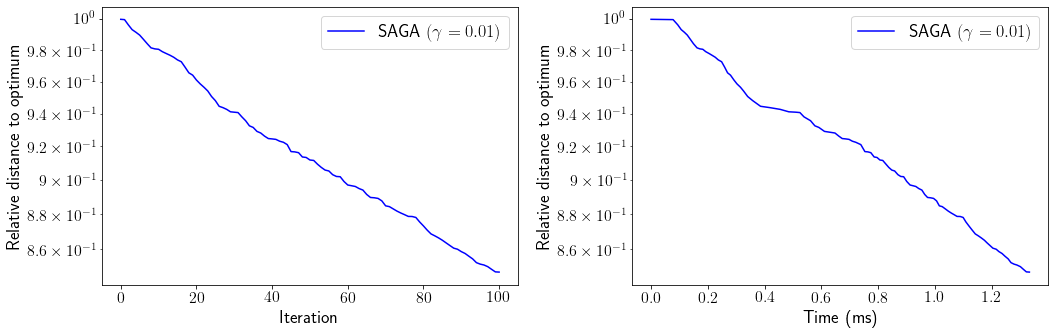

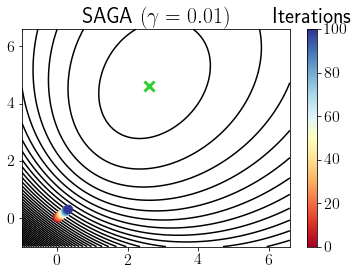

The step size is: 0.1
SAGA: final distance to the solution: 3.48e+00


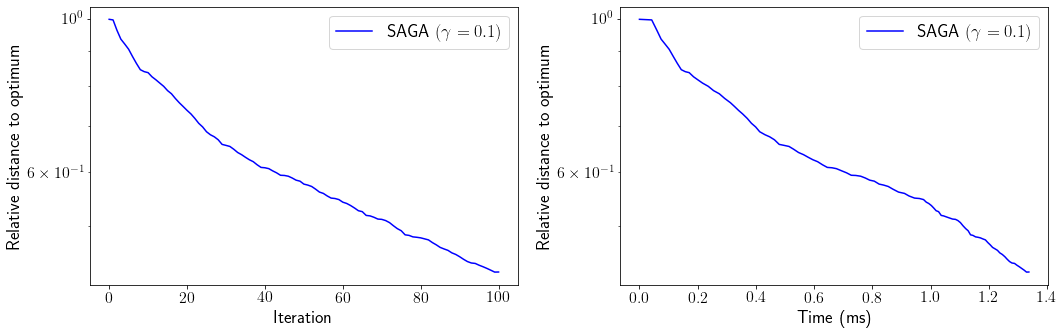

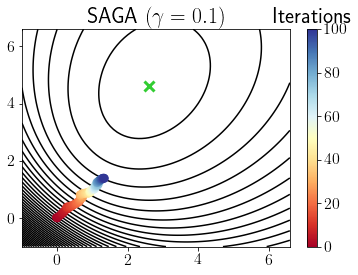

The step size is: 1.0
SAGA: final distance to the solution: 1.19e+00


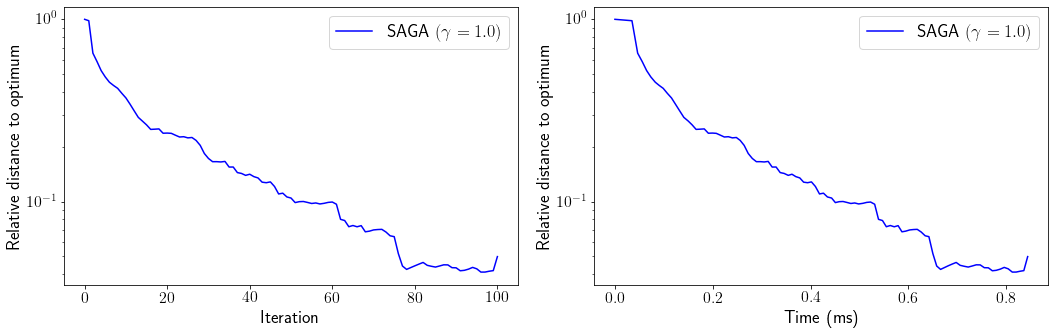

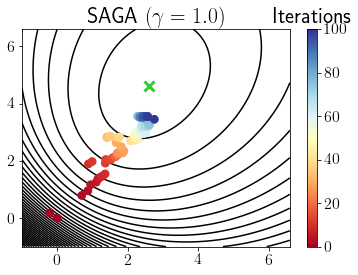

The step size is: 4.0
SAGA: final distance to the solution: 1.21e+00


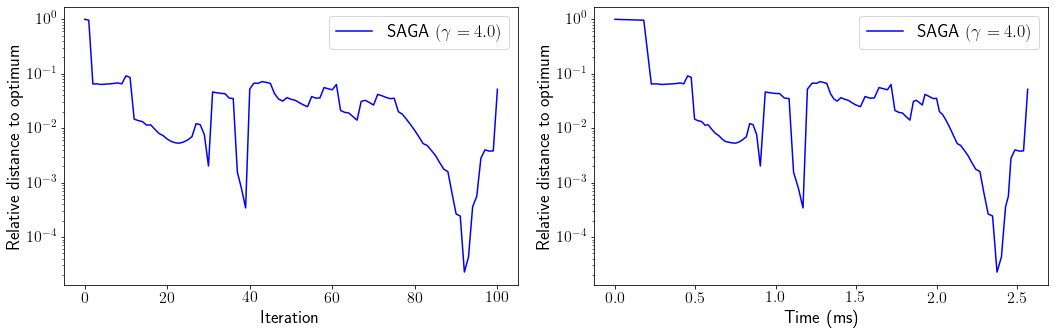

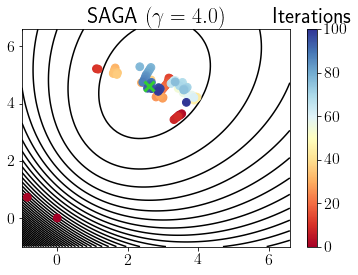

In [30]:
# Theoretical step size for SAGA (1/L_max)
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step_saga_theory = 1. / (max_squared_sum + lbda)

# Manually chosen step size
step_saga_list = np.array([1e-2, 1e-1, 1., 4.])
for step_saga in  step_saga_list:
    print('The step size is:', step_saga)
    if step_saga == step_saga_theory:
        label_saga = r"SAGA $\left(\gamma = 1 / L_{\max}\right)$"
    else:
        label_saga = r"SAGA $\left(\gamma = {}\right)$".format(step_saga)
        
    ## Optimization
    monitor_saga = monitor(saga, loss, x_min, (A, b, lbda))
    monitor_saga.run(x_init, iis, grad_i,
                     step=step_saga, 
                     n_iter=n_iter, store_every=1,
                     args=(A, b, lbda))
    relative_error_saga = [(x / monitor_saga.err[0])**2 for x in monitor_saga.err]
    print("SAGA: final distance to the solution: %.2e" % monitor_saga.err[-1])

    ## Convergence of the iterates (epoch figure)
    fig = plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.semilogy(np.arange(n_iter+1), relative_error_saga, "b", label=label_saga)
    plt.xlabel("Iteration")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
#     if step_saga == step_saga_theory:
#         plt.savefig('images/saga_convergence_iteration_step_size_theory.svg', bbox_inches='tight')
#     else:
#         step_str = str(step_saga).replace(".", "_")
#         plt.savefig('images/saga_convergence_iteration_step_size_' + step_str + '.svg', bbox_inches='tight')
    
    ## Convergence of the iterates (time figure)
    plt.subplot(1,2,2)
    plt.semilogy([t*1000 for t in monitor_saga.time_list], relative_error_saga, "b", label=label_saga)
    plt.xlabel("Time (ms)")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
    plt.tight_layout()
#     if save_figures:
#         if step_saga == step_saga_theory:
#             plt.savefig('images/saga_convergence_time_step_size_theory.svg', bbox_inches='tight')
#         else:
#             step_str = str(step_saga).replace(".", "_")
#             plt.savefig('images/saga_convergence_time_step_size_' + step_str + '.svg', bbox_inches='tight')
    if save_figures:
        if step_saga == step_saga_theory:
            plt.savefig('images/saga_convergence_step_size_theory.svg', bbox_inches='tight')
        else:
            step_str = str(step_saga).replace(".", "_")
            plt.savefig('images/saga_convergence_step_size_' + step_str + '.svg', bbox_inches='tight')
    plt.show()
    
    ## 2D path plot with iteration colorbar
    CS = plt.contour(X, Y, Z, nb_ellipses, colors='k')
    cm = plt.cm.get_cmap('RdYlBu')
    sc = plt.scatter(np.vstack(monitor_saga.x_list)[:,0], np.vstack(monitor_saga.x_list)[:,1],
                c=np.arange(len(monitor_saga.x_list)), marker='o', s=60, cmap=cm, zorder=2)
    clb = plt.colorbar(sc)
    clb.ax.set_title('Iterations')
    plt.scatter(x_min[0], x_min[1], s=100, linewidth=3, c='limegreen', marker='x', zorder=2) # Solution of the optim problem (L-BFGS)
    plt.title(label_saga)

    if save_figures:
        if step_saga == step_saga_theory:
            plt.savefig('images/saga_path_step_size_theory_iteration_colorbar.svg', bbox_inches='tight')
        else:
            step_str = str(step_saga).replace(".", "_")
            plt.savefig('images/saga_path_step_size_' + step_str + '_iteration_colorbar.svg', bbox_inches='tight')
    plt.show()

# 6. SGD
## (several passes over the data: oscillation around the solution)

### Stochastic indices

In [31]:
# Generate indices of random samples
n_iter_long = 10
freq = 1./5. # frequence of the monitoring
iis_long = np.random.randint(0, n, n_iter_long * n) # Random indices picked (over the length of the dataset)

### Select the step size and the monitoring frequence here below

Number of iterations:  1000000 (corresponding to  10  epochs)
Monitoring every  20000  iterations
The step size is: 1.0
SGD: final distance to the solution: 7.60e-01


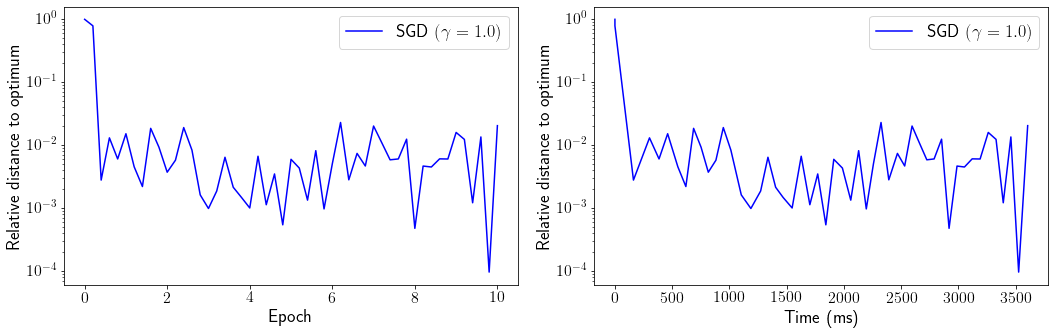

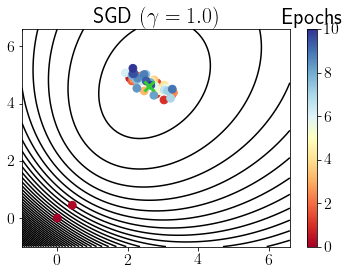

In [32]:
step_sgd_list = np.array([1.]) # step size

print("Number of iterations: ", n_iter_long * n, "(corresponding to ", n_iter_long, " epochs)")
print("Monitoring every ", int(round(n*freq)), " iterations")
for step_sgd in step_sgd_list:
    print('The step size is:', step_sgd)

    ## Optimization
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, iis_long, grad_i,
                    step=step_sgd, 
                    step_const=True, 
                    n_iter=n_iter_long * n, store_every=int(round(n*freq)),
                    args=(A, b, lbda))
    relative_error_sgd = [(x / monitor_sgd.err[0])**2 for x in monitor_sgd.err]
    print("SGD: final distance to the solution: %.2e" % monitor_sgd.err[-1])

    ## Convergence of the iterates (epoch figure)
    fig = plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.semilogy(np.arange(0, n_iter_long+freq, freq), relative_error_sgd, "b", 
                 label=r"SGD $\left(\gamma = {}\right)$".format(step_sgd))
    plt.xlabel("Epoch")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
#     if save_figures:
#         step_str = str(step_sgd).replace(".", "_")
#         plt.savefig('images/sgd_long_convergence_epoch_step_size_' + step_str + '.svg', bbox_inches='tight')
#     plt.show()
    
    ## Convergence of the iterates (time figure)
    plt.subplot(1,2,2)
    plt.semilogy([t*1000 for t in monitor_sgd.time_list], relative_error_sgd, "b", 
                 label=r"SGD $\left(\gamma = {}\right)$".format(step_sgd))
    plt.xlabel("Time (ms)")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
    plt.tight_layout()
#     if save_figures:
#         step_str = str(step_sgd).replace(".", "_")
#         plt.savefig('images/sgd_long_convergence_time_step_size_' + step_str + '.svg', bbox_inches='tight')

    if save_figures:
        step_str = str(step_sgd).replace(".", "_")
        plt.savefig('images/sgd_long_convergence_step_size_' + step_str + '.svg', bbox_inches='tight')
    plt.show()
    
    ## 2D path plot with iteration colorbar
    CS = plt.contour(X, Y, Z, nb_ellipses, colors='k')
    cm = plt.cm.get_cmap('RdYlBu')
    sc = plt.scatter(np.vstack(monitor_sgd.x_list)[:,0], np.vstack(monitor_sgd.x_list)[:,1],
                     c=np.arange(0, n_iter_long+freq, freq), marker='o', s=60, cmap=cm, zorder=2)
    clb = plt.colorbar(sc)
    clb.ax.set_title('Epochs')
    plt.scatter(x_min[0], x_min[1], s=100, linewidth=3, c='limegreen', marker='x', zorder=2) # Solution of the optim problem (L-BFGS)
    plt.title(r"SGD $\left(\gamma = {}\right)$".format(step_sgd))
    
    if save_figures:
        step_str = str(step_sgd).replace(".", "_")
        plt.savefig('images/sgd_long_path_step_size_' + step_str + '_iteration_colorbar.svg', bbox_inches='tight')
    plt.show()

# 7. Stochastic variance reduced methods 
## (several passes over the data: variance-reduction occurs)

### Select the step size and the monitoring frequence here below

Number of iterations:  1000000 (corresponding to  10  epochs)
Monitoring every  20000  iterations
The step size is : 1.0
SAGA: final distance to the solution: 3.79e-03


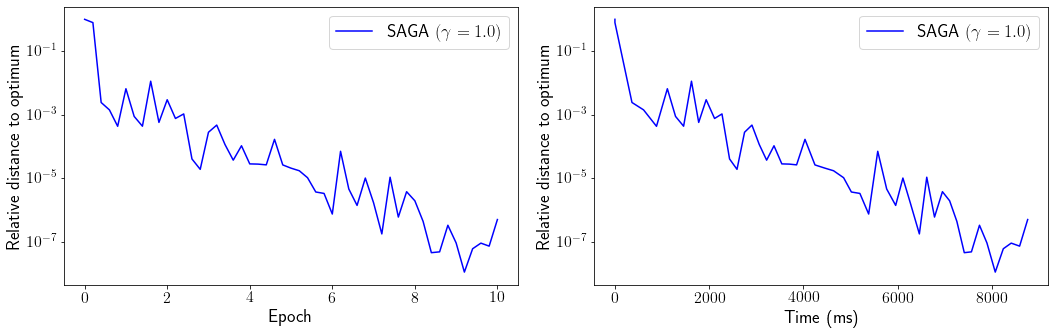

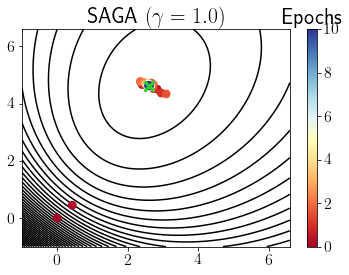

In [33]:
step_saga_list = np.array([1.]) # step size

print("Number of iterations: ", n_iter_long * n, "(corresponding to ", n_iter_long, " epochs)")
print("Monitoring every ", int(round(n*freq)), " iterations")
for step_saga in  step_saga_list:
    print('The step size is :', step_saga)
    if step_saga == step_saga_theory:
        label_saga = r"SAGA $\left(\gamma = 1 / L_{\max}\right)$"
    else:
        label_saga = r"SAGA $\left(\gamma = {}\right)$".format(step_saga)
        
    ## Optimization
    monitor_saga = monitor(saga, loss, x_min, (A, b, lbda))
    monitor_saga.run(x_init, iis_long, grad_i,
                     step=step_saga, 
                     n_iter=n_iter_long * n, store_every=int(round(n*freq)),
                     args=(A, b, lbda))
    relative_error_saga = [(x / monitor_saga.err[0])**2 for x in monitor_saga.err]
    print("SAGA: final distance to the solution: %.2e" % monitor_saga.err[-1])

    ## Convergence of the iterates (epoch figure)
    fig = plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.semilogy(np.arange(0, n_iter_long+freq, freq), relative_error_saga, "b", label=label_saga)
    plt.xlabel("Epoch")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
#     if step_saga == step_saga_theory:
#         plt.savefig('images/saga_long_convergence_epoch_step_size_theory.svg', bbox_inches='tight')
#     else:
#         step_str = str(step_saga).replace(".", "_")
#         plt.savefig('images/saga_long_convergence_epoch_step_size_' + step_str + '.svg', bbox_inches='tight')
#     plt.show()
    
    ## Convergence of the iterates (time figure)
    plt.subplot(1,2,2)
    plt.semilogy([t*1000 for t in monitor_saga.time_list], relative_error_saga, "b", label=label_saga)
    plt.xlabel("Time (ms)")
    plt.ylabel("Relative distance to optimum") # ||w_k - w^*||^2_2 / ||w_1 - w^*||^2_2
    # plt.ylabel(r"$\frac{||w_k - w^*||^2_2}{||w_1 - w^*||^2_2}$", rotation=0, labelpad=40)
    plt.legend()
    plt.tight_layout()
#     if save_figures:
#         if step_saga == step_saga_theory:
#             plt.savefig('images/saga_long_convergence_time_step_size_theory.svg', bbox_inches='tight')
#         else:
#             step_str = str(step_saga).replace(".", "_")
#             plt.savefig('images/saga_long_convergence_time_step_size_' + step_str + '.svg', bbox_inches='tight')

    if save_figures:
        if step_saga == step_saga_theory:
            plt.savefig('images/saga_long_convergence_step_size_theory.svg', bbox_inches='tight')
        else:
            step_str = str(step_saga).replace(".", "_")
            plt.savefig('images/saga_long_convergence_step_size_' + step_str + '.svg', bbox_inches='tight')
    plt.show()
    
    ## 2D path plot with iteration colorbar
    CS = plt.contour(X, Y, Z, nb_ellipses, colors='k')
    cm = plt.cm.get_cmap('RdYlBu')
    sc = plt.scatter(np.vstack(monitor_saga.x_list)[:,0], np.vstack(monitor_saga.x_list)[:,1],
                     c=np.arange(0, n_iter_long+freq, freq), marker='o', s=60, cmap=cm, zorder=2)
    clb = plt.colorbar(sc)
    clb.ax.set_title('Epochs')
    plt.scatter(x_min[0], x_min[1], s=100, linewidth=3, c='limegreen', marker='x', zorder=2) # Solution of the optim problem (L-BFGS)
    plt.title(label_saga)

    if save_figures:
        if step_saga == step_saga_theory:
            plt.savefig('images/saga_long_path_step_size_theory_iteration_colorbar.svg', bbox_inches='tight')
        else:
            step_str = str(step_saga).replace(".", "_")
            plt.savefig('images/saga_long_path_step_size_' + step_str + '_iteration_colorbar.svg', bbox_inches='tight')
    plt.show()

# 6. Numerical comparison